## Import Libraries

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import glob
import cv2
%matplotlib inline

Using TensorFlow backend.


## Camera Calibration

In this section we will use chessboard patterns images to calibrate our camera.
We will use this information to remove distornions in our camera images.

In [2]:
def calibrate_camera(folder, n_cols = 9 , n_rows = 6):
    '''
    Function takes a folder path, and information on the chessboard pattern.
    It will look for chessboard images in that folder and use it to compute 
    The cameraMatrix and distCoeffs.
    
    '''
    # Let us define where are the 3d points. We know this form the chessboar.
    objp = np.zeros((n_cols*n_rows,3), np.float32)
    objp[:,:2] = np.mgrid[0:n_cols,0:n_rows].T.reshape(-1,2)
    # List for image cordinates
    imgpoints = []
    # List for 3d cordinates
    objpoints = []
    print('Processing image ...')
    for fn in glob.iglob(folder+'/*.jpg'):
        print('\t', fn)
        img = cv2.imread(fn)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, cornes = cv2.findChessboardCorners(gray,(n_cols,n_rows))
        if ret == True: # If corners found
            imgpoints.append(cornes)
            objpoints.append(objp)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return mtx,dist
        

In [3]:
def undistort_image(image, mtx, dist, plot=False):
    """
    Removes camera distorion from image.
    Function takes image, cameraMatrix and distCoeffs,
    """
    undst = cv2.undistort(image, mtx, dist, None, mtx)
    if plot:
        # Visualize undistortion
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(image)
        ax1.set_title('Original Image')
        ax2.imshow(undst)
        ax2.set_title('Undistorted Image')
    return undst

We will calibrate our camera and undistort a sample image

Processing image ...
	 camera_cal/calibration10.jpg
	 camera_cal/calibration12.jpg
	 camera_cal/calibration20.jpg
	 camera_cal/calibration8.jpg
	 camera_cal/calibration4.jpg
	 camera_cal/calibration17.jpg
	 camera_cal/calibration6.jpg
	 camera_cal/calibration1.jpg
	 camera_cal/calibration15.jpg
	 camera_cal/calibration16.jpg
	 camera_cal/calibration11.jpg
	 camera_cal/calibration19.jpg
	 camera_cal/calibration5.jpg
	 camera_cal/calibration2.jpg
	 camera_cal/calibration14.jpg
	 camera_cal/calibration18.jpg
	 camera_cal/calibration3.jpg
	 camera_cal/calibration13.jpg
	 camera_cal/calibration7.jpg
	 camera_cal/calibration9.jpg


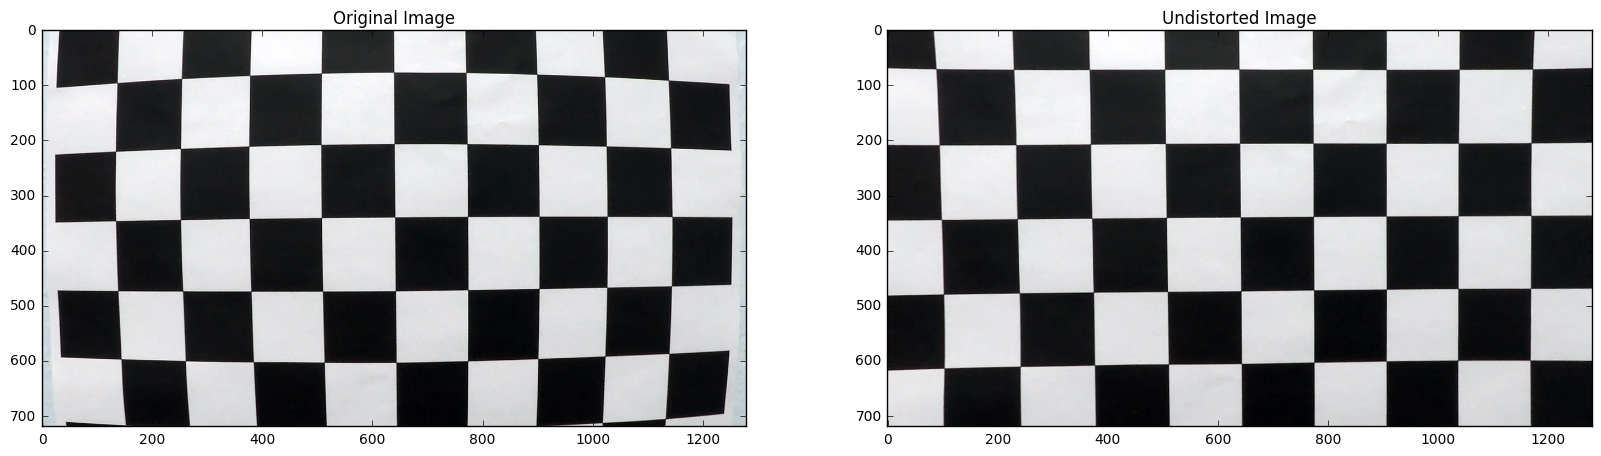

In [4]:
# Calibrate Camera
mtx,dist = calibrate_camera('camera_cal')
# Undistor Image
img = cv2.imread('camera_cal/calibration1.jpg')
# Show results
undst= undistort_image(img, mtx, dist, plot=True)


Do distorion correction on the sample image


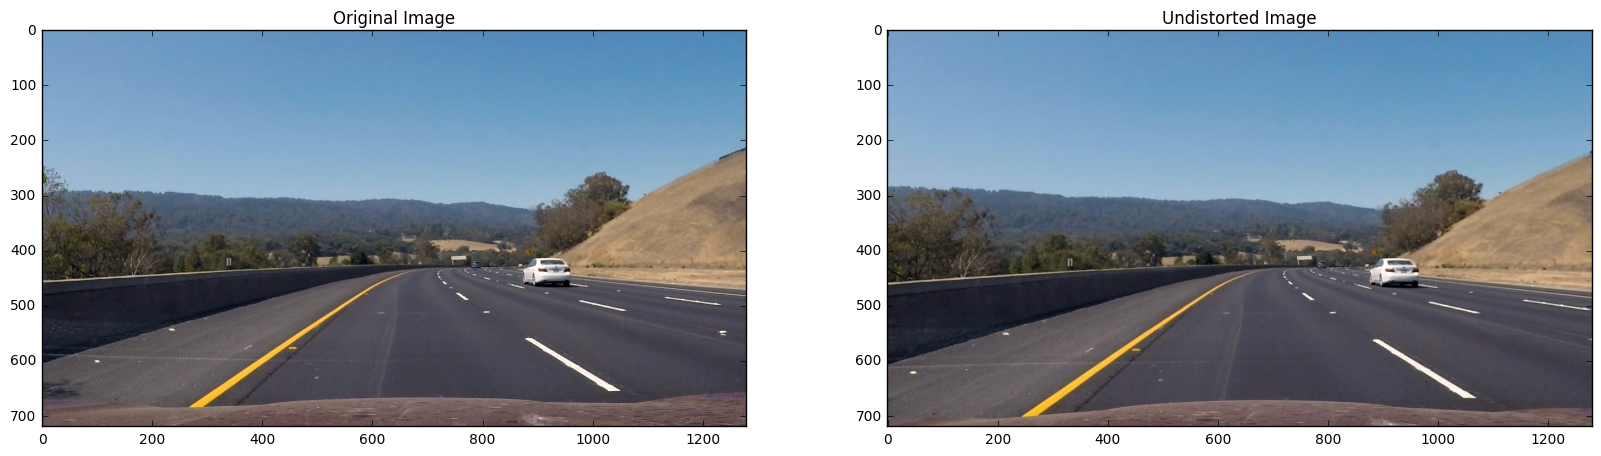

In [5]:
# Load the image and undistor it
image = cv2.imread('test_images/test3.jpg')
RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undst= undistort_image(RGB, mtx, dist, plot=True)

## Birdeye view.

Now we will map 4 points that we know defines a plane and use it to compute the perspective transformation of the camera.

We will use this information to warp the image to a a top-view of the plane.
This will allow us to have a top view of the road ahead of the car.

In [6]:
def warp(undist, plot = False):
    """
    Warp Image to remove perspective tranformation and transform to top down view.
    """
    img_size = (undist.shape[1], undist.shape[0])
    src = np.float32([[580,460],
                      [705,460],
                      [1046,680],
                      [270,680]])
    pts = src.astype(np.int32)
    pts = pts.reshape((-1,1,2))


    dst = np.float32([[340+0,100],
                      [340+600,100],
                      [340+600,700],
                      [340+0,700]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    birdview = cv2.warpPerspective(undist, M, img_size)
    
    if plot:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        
        undist_ = np.copy(undist)
        cv2.polylines(undist_,[pts],True,(255,0,0),3)
        cv2.polylines(undist_,[pts],True,(255,0,0),3)
        
        
        ax1.imshow(undist_)
        ax1.set_title('Original Image')
        
               
        birdview_ = np.copy(birdview)
        cv2.rectangle(birdview_,(340,100),(940,700),(255,0,0),3)
        ax2.imshow(birdview_)
        ax2.set_title('Undistorted and Warped Image')
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return birdview, M

Show results

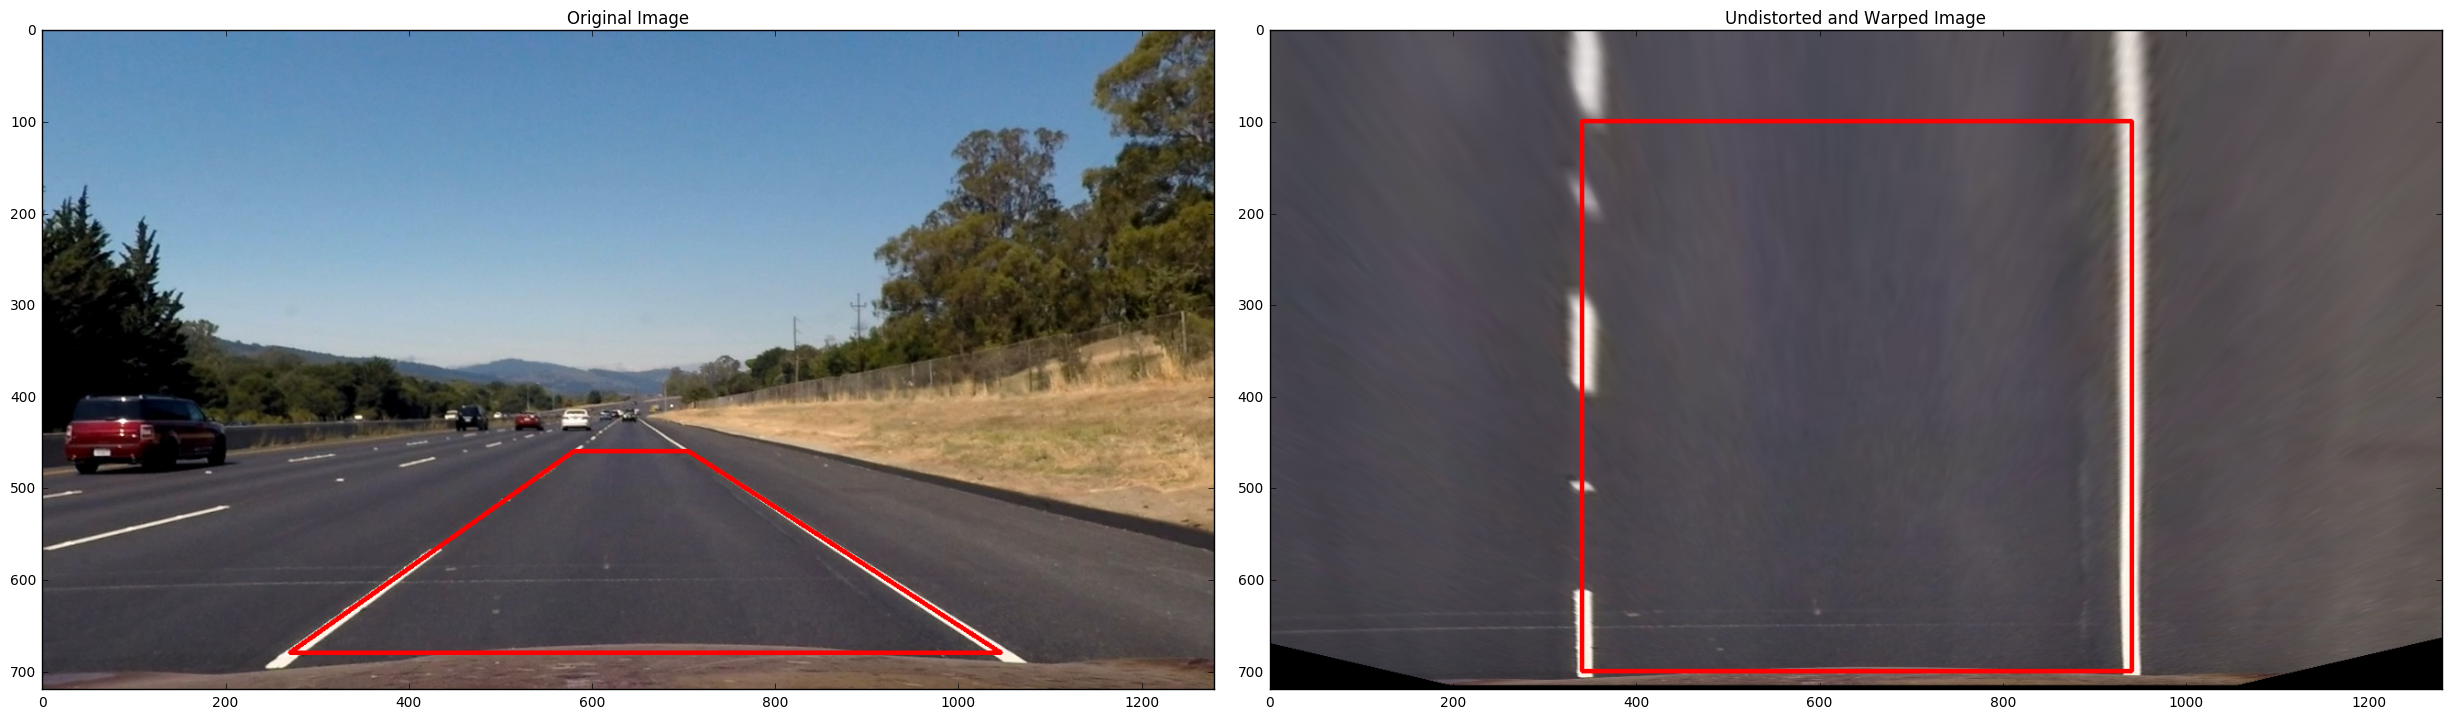

In [7]:
# Load the image and undistor it
image = cv2.imread('test_images/straight_lines2.jpg')
RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undst= undistort_image(RGB, mtx, dist)
# Birdeye view
warped,M = warp(undst, True)


## Binary images of lanes

We do a combination of methods ( color space and gradients) to extrac a binary image of lanes.
There is no "ground truth" here, just visual verification that the pixels identified as part of the lane lines are, in fact, part of the lines.

In [8]:
def color_code(img, s_thresh=(30, 255), sx_thresh=(30, 100), plot=False):
    """
    We will color code an RGB image with different image segmentation techniques.
    The red channel is using threhsold of the L channel of  HSV colorspace and the B channel LAB colorspace.
    The green channel is based on thresholding the sobel gradients on the X direction.
    The blue    channel is based on a combination of the sobel_x  and the saturation channel of HSV.

    """
    
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Convert to LAB color space and separate the B channel
    LAB = cv2.cvtColor(img, cv2.COLOR_RGB2Lab).astype(np.float)
    b_channel = LAB[:,:,2]

    
    # Color Space segmentation
    LM = l_channel>240
    BM = b_channel>150
    
    c_bin =l_channel*LM+BM*b_channel
    c_bin = c_bin.astype(np.uint8)*255
    kernel = np.ones((3,3),np.uint8)

    c_bin = cv2.erode(c_bin, kernel)

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    color_coded = np.dstack(( c_bin, sxbinary, s_binary*sxbinary))
    
    
    if plot:
        
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(img)
        ax1.set_title('Original Image')

        ax2.imshow(color_coded)
        ax2.set_title('Color Coded Result')
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return color_coded 

Now we will color coded and undistorned image and the birdview.

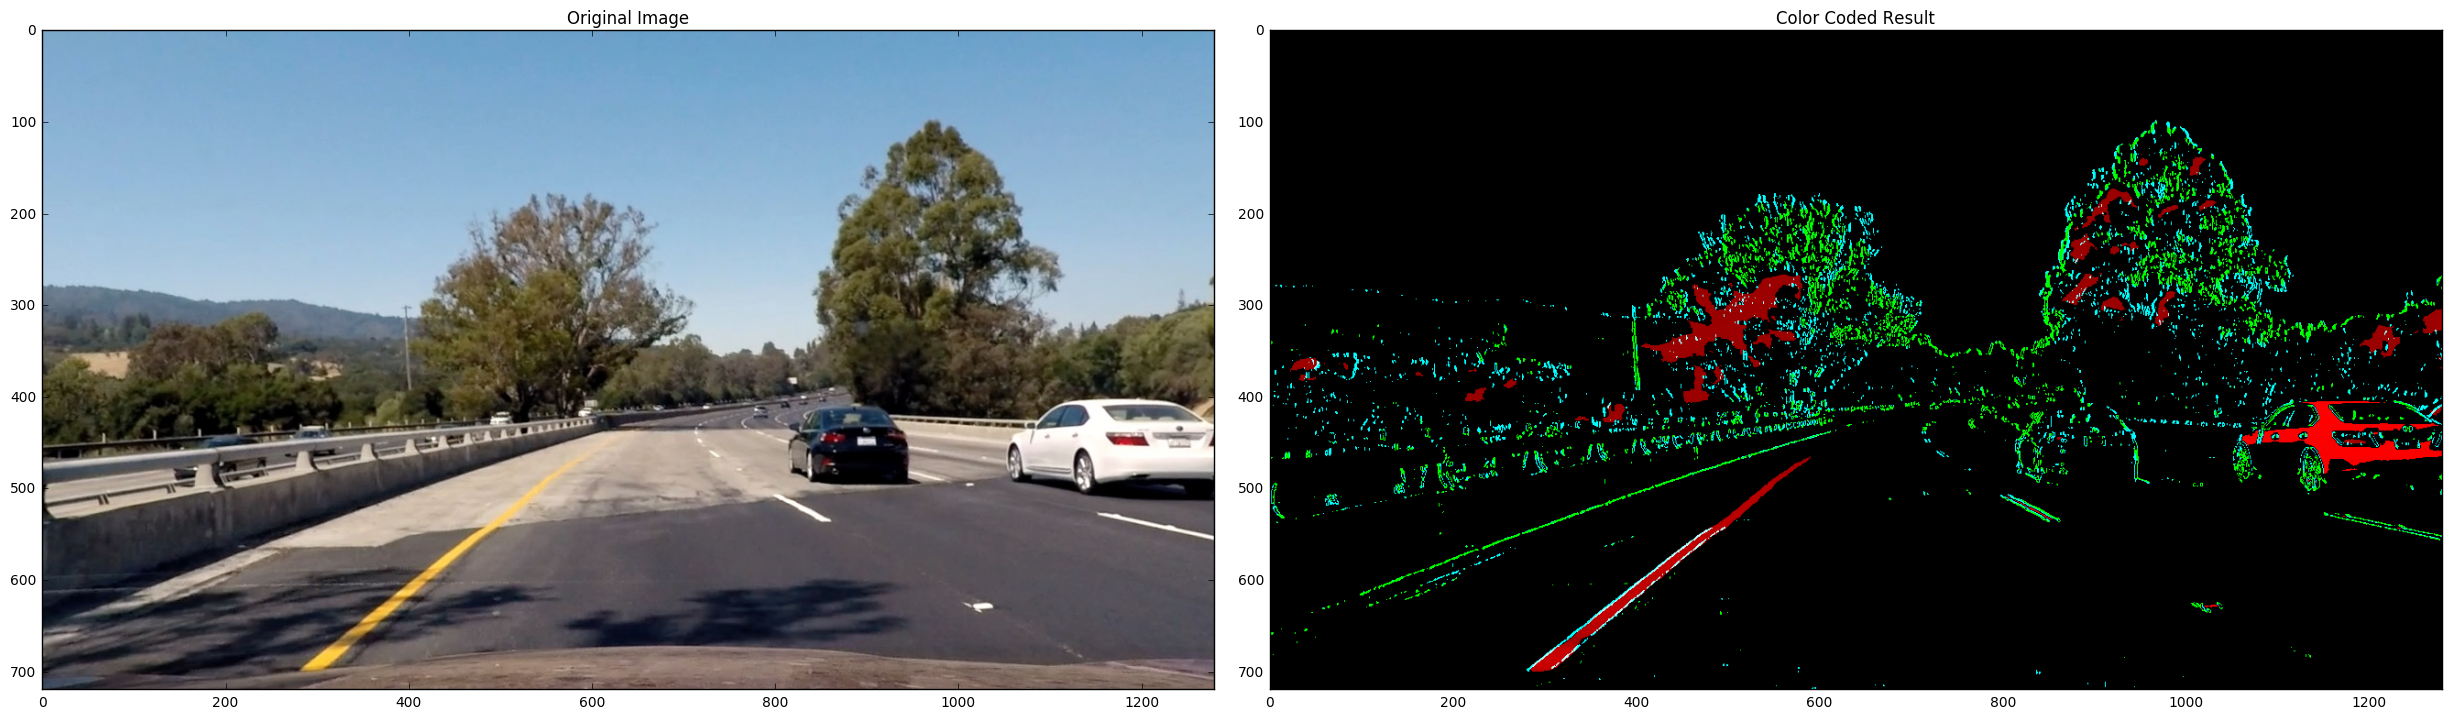

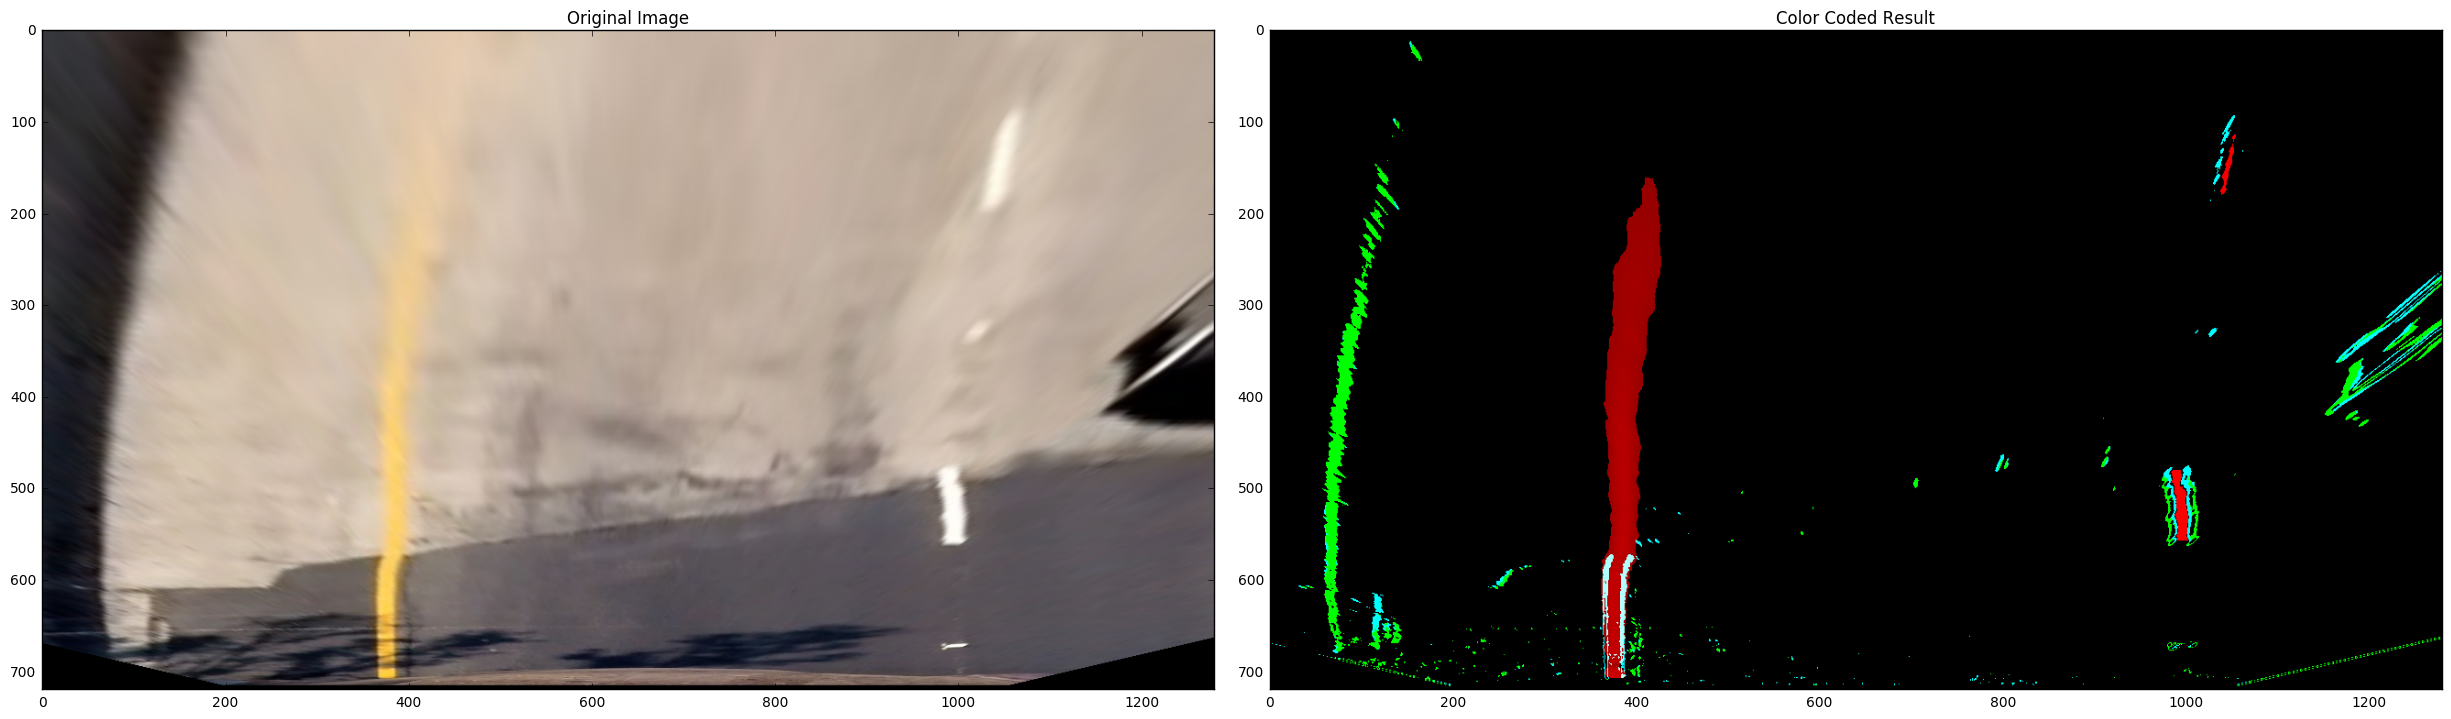

In [9]:
# Load the image and undistor it
image = cv2.imread('test_images/test4.jpg')
RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undst= undistort_image(RGB, mtx, dist)
# Color code RGB
cc1 = color_code(undst, plot=True)
# Birdeye view
warped,M = warp(undst)

cc2 = color_code(warped, plot=True)

The binary image is achieved by looking for pixel > 0  on the color coded images

In [10]:
def binary_image(undst,  plot=False):
    """
    Compute Binary Image by doing double threshold.
    """

    # Color code 1
    cc1 = color_code(undst)
    # Color code 1 warped
    wcc1,M =  warp(cc1)
    
    wcc1 = wcc1
    # Warp 2
    w2,_ = warp(undst)
    # Color code 2 warped
    wcc2 = color_code(w2)
    wcc2 = wcc2
    
    binary_image =  255*(wcc2.mean(axis=2) +  wcc1.mean(axis=2))>0
    binary_image = binary_image.astype(np.uint8)
    
    

    if plot:
        
        # Plot the result
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
        f.tight_layout()

        ax1.imshow(undst)
        ax1.set_title('Original Image')

        ax2.imshow(wcc1)
        ax2.set_title('Warped Color Coded 1')
        
        ax3.imshow(wcc2)
        ax3.set_title('Warped Color Coded 2')
        
        ax4.imshow(binary_image)
        ax4.set_title('binary_image')
    return binary_image,M
    


Show results

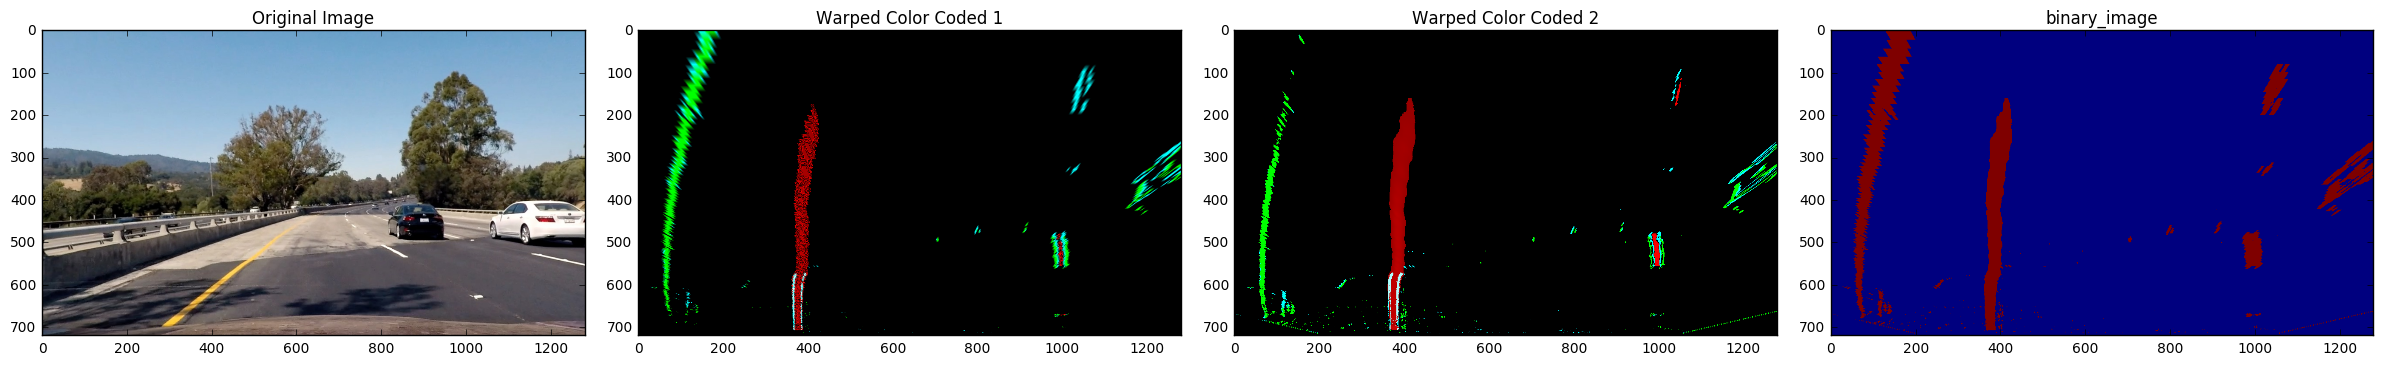

In [11]:
# Load the image and undistor it
image = cv2.imread('test_images/test4.jpg')
RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorded= undistort_image(RGB, mtx, dist)
binary = binary_image(undistorded, True)[0]

## Find lanes and define area for future search
This code finds the potential pixels of left and right lane.
It does it by looking for histogram peaks on different peaces of the image.


In [12]:
def find_lanes(binary_warped, plot = False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.astype(np.uint8)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 5
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 120
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if plot:
        plt.imshow(out_img)
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return (lefty,leftx),(righty,rightx)


Show probable lane pixels

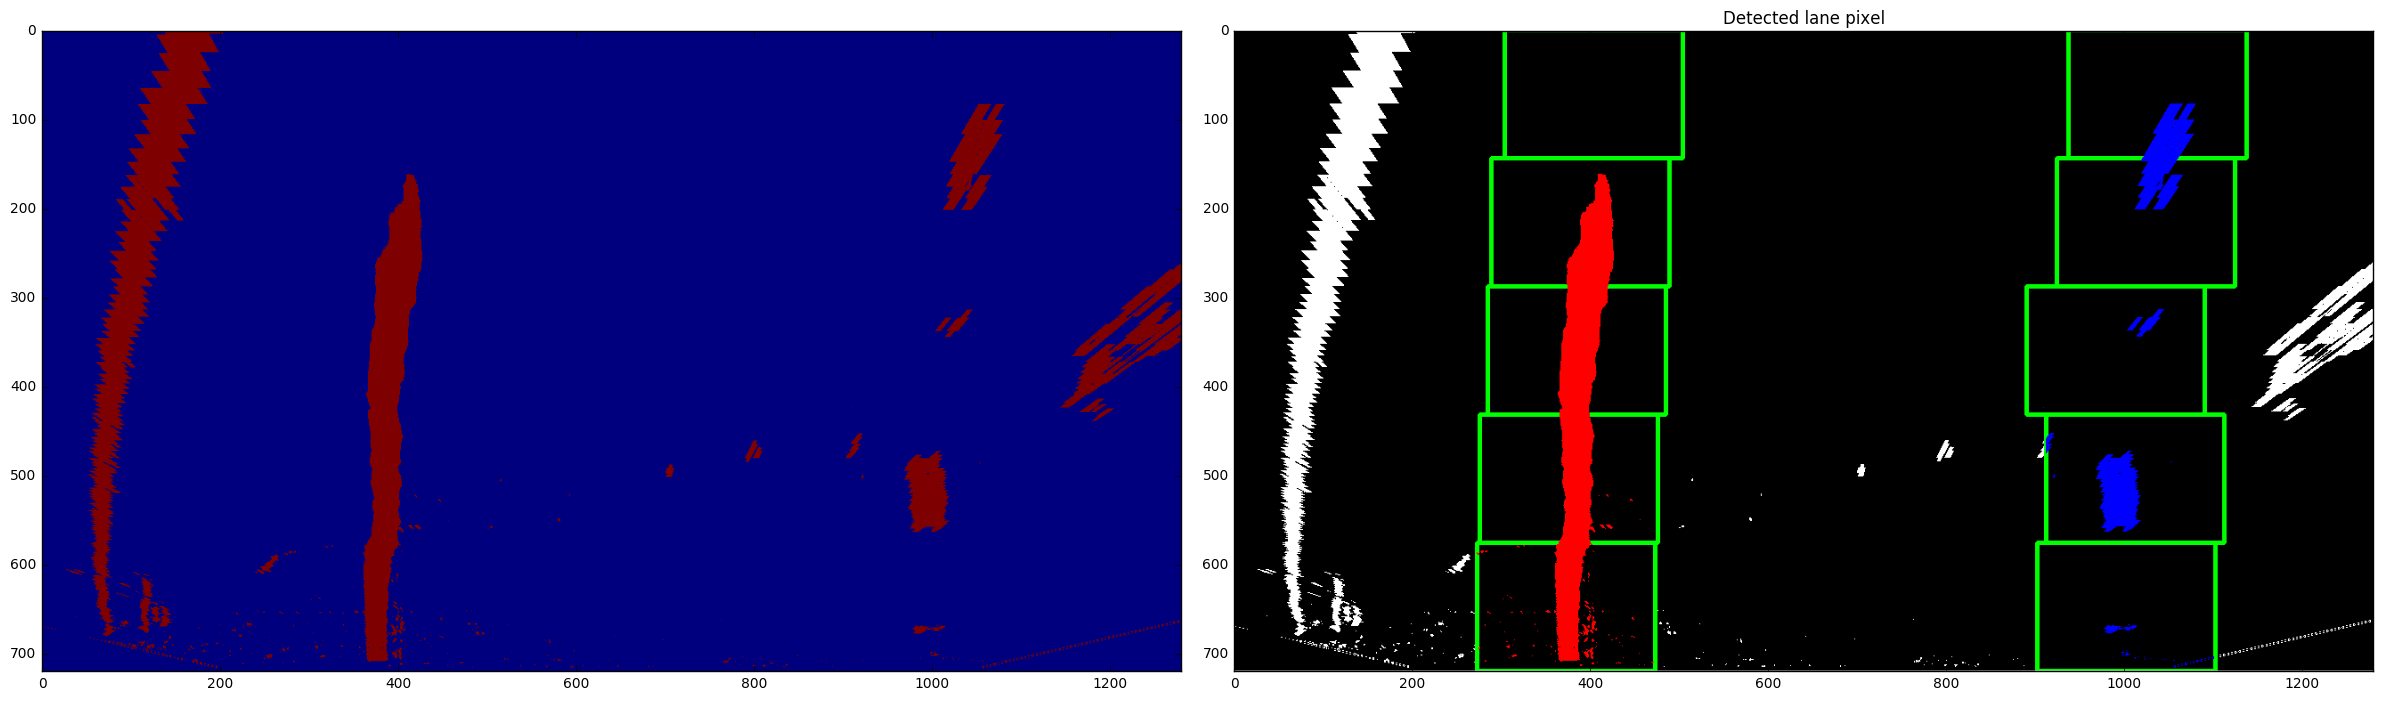

In [13]:
# Load the image and undistort it
image = cv2.imread('test_images/test4.jpg')

RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorded= undistort_image(RGB, mtx, dist)
binary,M= binary_image(undistorded)

# Plot the result
f, (ax1, ax2 ) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary)
ax2.set_title('Binary Image')
        
ax2.set_title('Detected lane pixel')
plt.sca(ax2)
# Find lane and plot it
_=find_lanes(binary,plot=True)


Class to track lines

In [14]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = []
        

       
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 

        #Maks
        self.mask = np.ones((720,1280),dtype=np.uint8)


    def append(self,y,x):
        if np.unique(x).shape[0] > 100:
            self.detected = True
        else:
            self.detected = False
            
        if self.detected:
           
            # Fit line to polynomial
            current_fit =  np.polyfit(y, x, 2)
            # Compute difference betweehn last fits
            self.diffs = current_fit - self.diffs
            
            self.current_fit.append(current_fit)
        
            #Define array of y pixels
            ploty = np.linspace(0, 720-1, 1280 )
            
            # Find X pixels from current fit
            fitx = current_fit[0]*ploty**2 + current_fit[1]*ploty + current_fit[2]
            fitx[fitx > 1279]=1279
            fitx[fitx <0]=0
            fitx = np.floor(fitx).astype(np.int)
            
            #Store x values of the last fit
            self.recent_xfitted.append(fitx)
            
            
            # Create mask to aid the next frame
            mask = np.zeros((720,1280),dtype=np.uint8)
            mask[np.floor(ploty).astype(np.int),fitx]= 1
            kernel = np.ones((1,100),np.uint8)
            mask = cv2.dilate(mask,kernel,iterations = 2)
            
            self.mask = mask
            
            #Compute fit with world dimensions
            ym_per_pix = 50.0/720. # meters per pixel in y dimension
            xm_per_pix = 3.7/600. # meters per pixel in x dimension
            
            fit_w = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
            curvature = ((1 + (2*fit_w[0]*719*ym_per_pix + fit_w[1])**2)**1.5) / np.absolute(2*fit_w[0])
            self.radius_of_curvature = curvature
            
            
            
            
 
            #average x values of the fitted line over the last 4 iterations
            self.bestx = np.array(self.recent_xfitted)[-4:,:].mean(axis=0)  
        
            self.line_base_pos = self.bestx.min()  
            #polynomial coefficients averaged over the last n iterations
            
            self.best_fit =  np.polyfit(ploty, self.bestx, 2)
        

Show results

In [15]:
# Load the image and undistort it
image = cv2.imread('test_images/test4.jpg')

RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorded= undistort_image(RGB, mtx, dist)
binary,M= binary_image(undistorded)

left = Line()
right = Line()


left_pixels,right_pixels=find_lanes(binary)
left.append(left_pixels[0],left_pixels[1])
right.append(right_pixels[0],right_pixels[1])

Show the mask used to filter future image

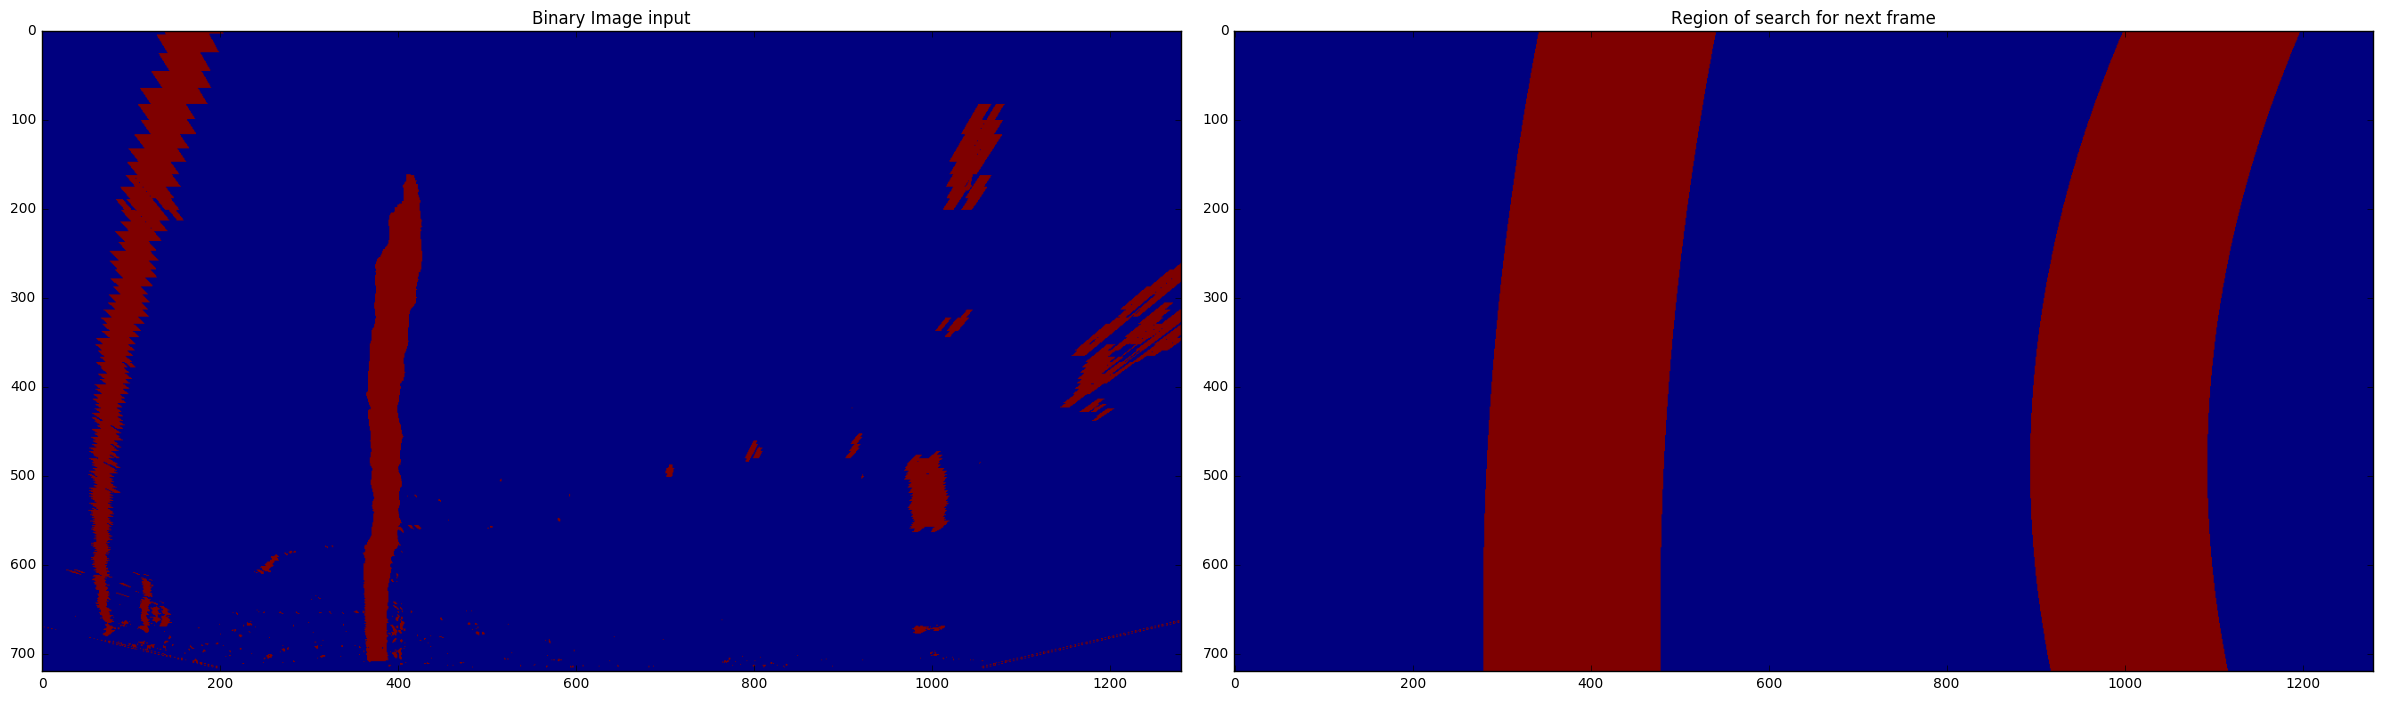

In [16]:
# Plot the result
f, (ax1, ax2 ) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary)
ax1.set_title('Binary Image input')
        
ax2.set_title('Region of search for next frame')
plt.sca(ax2)
# Find lane and plot it
plt.imshow(left.mask+right.mask)



# Now let us Warp it back to the carview

In [17]:
def carview(undist,M,left_fit,right_fit):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist[:,:,]).astype(np.uint8)    
    # Generate x and y values for plotting
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
#     print(color_warp.shape,color_warp.dtype)
    # Draw the lane onto 
    cv2.drawContours(color_warp,np.int_([pts]),-1,(255,0,0),30)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


    Minv = np.linalg.inv(M)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 0.77, newwarp, 0.6, 0)
    return(result)

Shows resuls so far

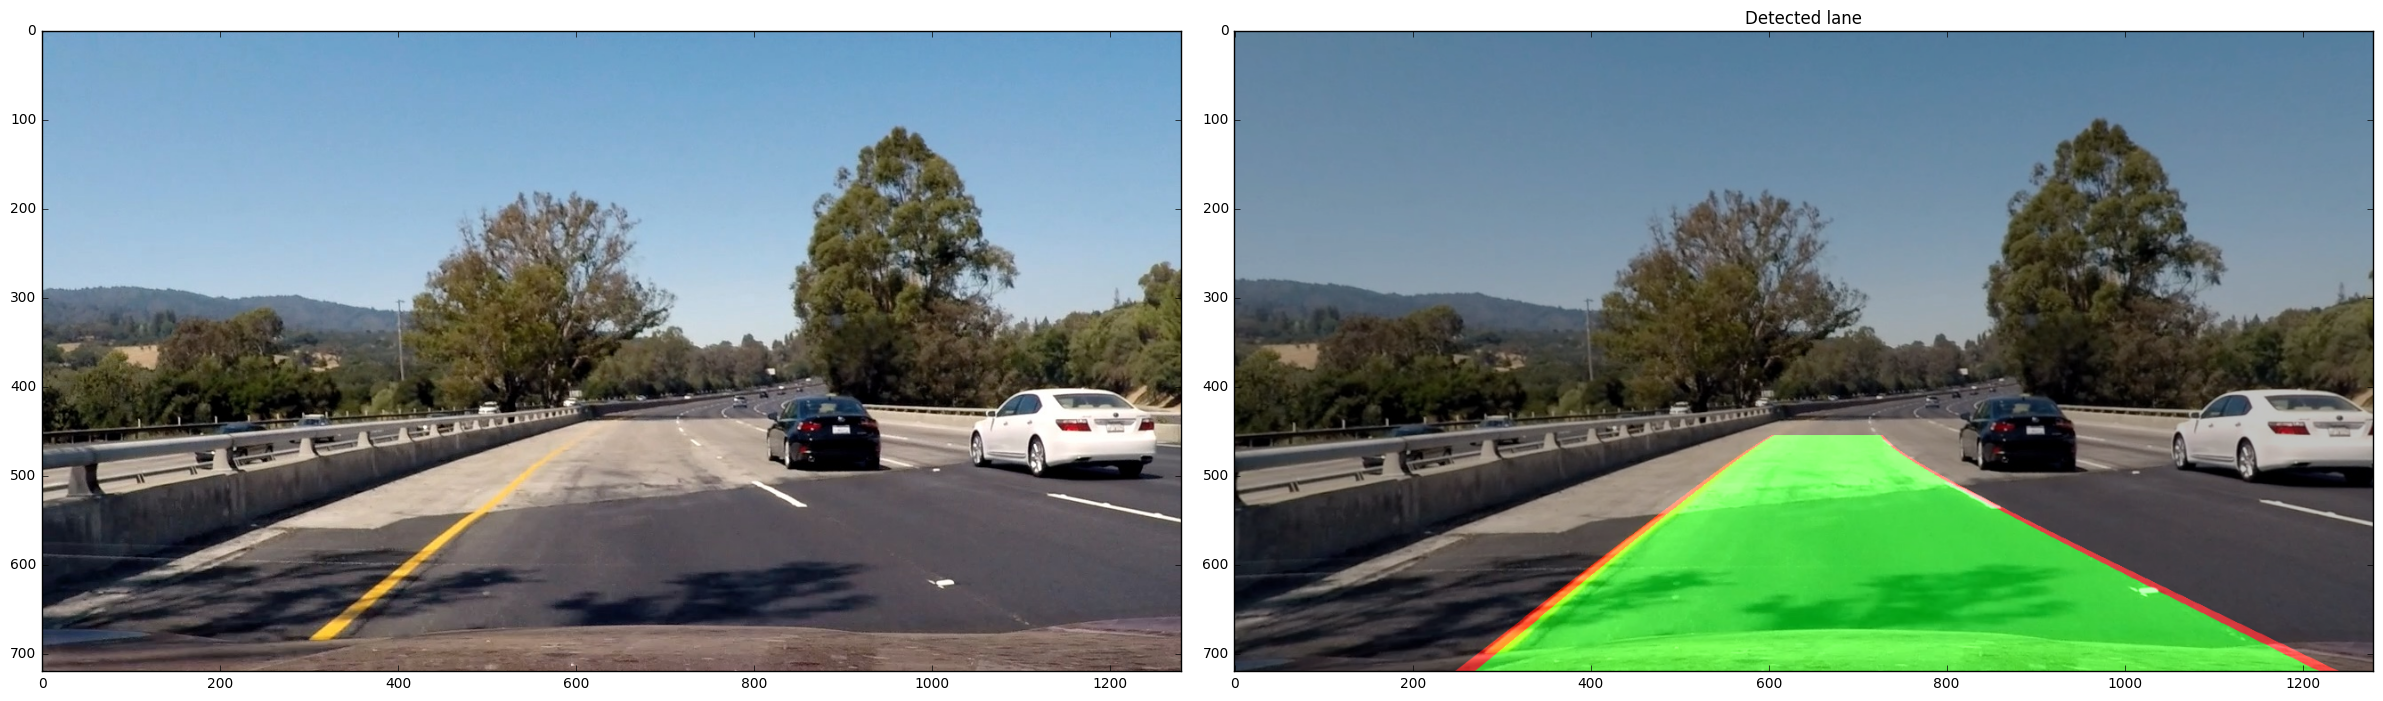

In [18]:
# Load the image and undistort it
image = cv2.imread('test_images/test4.jpg')
RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

undistorded= undistort_image(RGB, mtx, dist)
binary,M = binary_image(undistorded)

left = Line()
right = Line()

left_pixels,right_pixels=find_lanes(binary)

left.append(left_pixels[0],left_pixels[1])
right.append(right_pixels[0],right_pixels[1])

mask = left.mask + right.mask


result = carview(undistorded,M, left.best_fit, right.best_fit)
# Plot the result
f, (ax1, ax2 ) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(RGB)
ax2.set_title('Original Image')
        
ax2.set_title('Detected lane')
ax2.imshow(result)


## Create pipeline to process video feed

In [19]:
left = Line()
right = Line()
curvature=[]
def process_image(RGB):
    global left
    global right
    global curvature
    global mtx
    global dist
    # Undistor image
    undistorded= undistort_image(RGB, mtx, dist)
    
    # Get Binary mask
    binary,M = binary_image(undistorded)
    binary = binary*left.mask + binary*right.mask
    binary = binary>0
    
    
    # Find candidate Pixels
    left_pixels,right_pixels=find_lanes(binary)
    # Update lines
    left.append(left_pixels[0],left_pixels[1])
    right.append(right_pixels[0],right_pixels[1])

    dist_to_center = (3.7/6)*(np.average([left.line_base_pos,right.line_base_pos])-640)
    result = carview(undistorded,M, left.best_fit, right.best_fit)
    
    font = cv2.FONT_HERSHEY_COMPLEX
    str1 = 'Distance to center of the road = {0:.2f} cm'.format(dist_to_center)
    cv2.putText(result,str1,(80,30), font, 1 ,(255,255,255),2,cv2.LINE_AA)
    if left.radius_of_curvature and right.radius_of_curvature:
        CURV = (left.radius_of_curvature+right.radius_of_curvature)/2
        CURV /=1000
        curvature.append(CURV)
        computed_curvature = np.array(curvature)[-25:].mean(axis=0) 
        if computed_curvature < 5:
            str2 = 'Detected Curve with curvature of {0:.2f} km'.format(computed_curvature)
            cv2.putText(result,str2,(80,60), font, 1,(255,255,255),2,cv2.LINE_AA)   
    return result

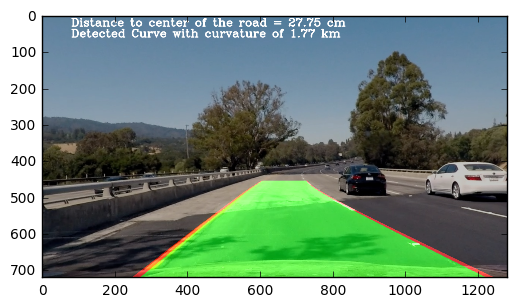

In [ ]:
result = process_image(RGB)
plt.imshow(result)

## Process Video

In [ ]:
from moviepy.editor import VideoFileClip

left = Line()
right = Line()
curvature=[]
clip1 = VideoFileClip("./project_video.mp4")
wclip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time wclip.write_videofile('out.mp4', audio=False)


[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


 19%|█▊        | 236/1261 [00:56<04:11,  4.08it/s]